<a href="https://colab.research.google.com/github/Elango-Natarajan/PredatorFree_Hakarimata_2025/blob/main/PredatorFree_Elango.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytesseract

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00


In [3]:
import cv2
import pytesseract
import re
from datetime import datetime
from ultralytics import YOLO
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

# ----------------------------
# Load YOLO model
# ----------------------------
model = YOLO('yolov8n.pt')

# ----------------------------
# OCR Cleanup Function
# ----------------------------
def clean_ocr_text(text):
    """Fix common OCR mistakes before regex parsing"""
    replacements = {
        "indgt": "inHg",   # misread pressure
        "inH9": "inHg",
        "inHG": "inHg",
        "inHO": "inHg",
        "inHq": "inHg",
        "INHG": "inHg",

        "0 €": "°C",       # misread °C
        "0€": "°C",
        " €": "°C",
        "oC": "°C",
        " OC": "°C",
        " C": "°C",
        "° C": "°C",
    }
    for wrong, right in replacements.items():
        text = text.replace(wrong, right)
    return text

# ----------------------------
# Load Image Safely
# ----------------------------
def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"❌ File not found: {image_path}")
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"❌ Could not load image: {image_path}")
    return img

# ----------------------------
# Extract Metadata
# ----------------------------
def extract_metadata(image_path):
    """Extract time, date, temperature, pressure, and location from image text"""
    img = load_image(image_path)

    # Convert to grayscale and enhance contrast
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.convertScaleAbs(gray, alpha=1.5, beta=20)

    # OCR
    custom_config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(gray, config=custom_config)
    text = text.replace("\n", " ")
    text = clean_ocr_text(text)
    print(f"OCR Cleaned Text ({image_path}):", text)

    metadata = {
        'pressure': None,
        'temperature': None,
        'date': None,
        'time': None,
        'location': None
    }

    # --- Pressure (29.30 inHg) ---
    pressure_match = re.search(r'(\d+[.,]?\d*)\s*inHg', text, re.IGNORECASE)
    if pressure_match:
        metadata['pressure'] = float(pressure_match.group(1).replace(",", "."))

    # --- Temperature (e.g., 4°C) ---
    temp_match = re.search(r'(-?\d+)\s*°C', text, re.IGNORECASE)
    if temp_match:
        metadata['temperature'] = float(temp_match.group(1))

    # --- Date & Time ---
    datetime_match = re.search(r'(\d{2}/\d{2}/\d{4})\s+(\d{1,2}:\d{2}[AP]M)', text)
    if datetime_match:
        metadata['date'] = datetime.strptime(datetime_match.group(1), '%m/%d/%Y').date()
        metadata['time'] = datetime.strptime(datetime_match.group(2), '%I:%M%p').time()

    # --- Location ---
    location_match = re.search(r'CAMERA\d+', text, re.IGNORECASE)
    if location_match:
        metadata['location'] = location_match.group(0).upper()

    return metadata

# ----------------------------
# Possum Detection
# ----------------------------
def detect_possums(image_path, confidence=0.5):
    """Detect possums in image using YOLOv8"""
    img = load_image(image_path)
    results = model.predict(source=img, conf=confidence)

    possum_count = 0
    output_img = img.copy()

    for result in results:
        for box in result.boxes:
            if int(box.cls) == 74:  # COCO class ID for possum (assuming 74 is possum)
                possum_count += 1
                x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
                cv2.rectangle(output_img, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(output_img, f"Possum {possum_count}", (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    return possum_count, output_img

# ----------------------------
# Full Pipeline for One Image
# ----------------------------
def process_surveillance_image(image_path, show_image=False):
    """Full processing pipeline for a single image"""
    # Extract metadata
    metadata = extract_metadata(image_path)

    # Detect Possums
    possum_count, detected_img = detect_possums(image_path)

    # Add metadata to image
    info_text = (f"Date: {metadata['date']} | Time: {metadata['time']} | "
                 f"Temp: {metadata['temperature']}℃ | "
                 f"Location: {metadata['location']} | "
                 f"Possums detected: {possum_count}")

    cv2.putText(detected_img, info_text, (10, 30),
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    if show_image:
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

    return metadata, possum_count

# ----------------------------
# Process Multiple Images
# ----------------------------
def process_multiple_images(image_folder, output_csv="results.csv"):
    """Process all images in a folder and save metadata + detections to CSV"""
    all_results = []

    # Collect all JPG/PNG images
    image_list = glob.glob(os.path.join(image_folder, "*.JPG")) + \
                 glob.glob(os.path.join(image_folder, "*.PNG"))

    if not image_list:
        print(f"❌ No images found in {image_folder}")
        return None

    for image_path in image_list:
        metadata, possum_count = process_surveillance_image(image_path)
        row = {
            'image': os.path.basename(image_path),
            'pressure': metadata['pressure'],
            'temperature': metadata['temperature'],
            'date': metadata['date'],
            'time': metadata['time'],
            'location': metadata['location'],
            'possum_count': possum_count
        }
        all_results.append(row)

    df = pd.DataFrame(all_results)
    df.to_csv(output_csv, index=False)
    print(f"\n✅ Saved results to {output_csv}")
    return df

# ----------------------------
# Example Usage
# ----------------------------
if __name__ == "__main__":
    # Path to your images folder
    image_folder = "/content/sample_data/final"

    # Run pipeline on all images in folder
    df = process_multiple_images(image_folder, output_csv="results.csv")
    if df is not None:
        print(df)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
OCR Cleaned Text (/content/sample_data/final/IMG_0381.JPG): a E i 3 Vaowa chs lila) ole @ 09/03/2025 07:05PM°CAMERA‘ 

0: 384x640 (no detections), 347.0ms
Speed: 15.0ms preprocess, 347.0ms inference, 20.2ms postprocess per image at shape (1, 3, 384, 640)
OCR Cleaned Text (/content/sample_data/final/IMG_0415.JPG): | 28.62 inHg} 8 90 @ 09/06/2025 05:55AM°CAMERA 

0: 384x640 (no detections), 139.6ms
Speed: 3.8ms preprocess, 139.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
OCR Cleaned Text (/content/sample_data/final/IMG_0524.JPG): 3 28.65 inHg 8 70 @ 09/16/2025 03:07AM°CAMERA‘ | 

0: 384x640 (no detections), 137.9ms
Speed: 3.6ms preprocess, 137.9ms inferenc

In [4]:
import pandas as pd
# This code is to visualise the data

# Load your file (replace path if needed)
df = pd.read_csv("results.csv")

# Combine date and time into one datetime column
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")

# Extract date and hour
df["date_only"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour

# --- Full 24-hour table ---
full_table = (
    df.groupby(["date_only", "hour"]).size().reset_index(name="image_count")
    .pivot(index="date_only", columns="hour", values="image_count")
    .fillna(0).astype(int)
)

print("=== Full Date × Hour Table (0–23) ===")
print(full_table)

# --- Condensed summary (only active hours) ---
# Drop rows with NaN in 'hour' before processing for condensed summary
condensed = (
    df.dropna(subset=['hour'])
    .groupby(["date_only", "hour"])
    .size().reset_index(name="image_count")
)

print("\n=== Condensed Summary (Only Active Hours) ===")
for date, group in condensed.groupby("date_only"):
    print(f"\nDate: {date}")
    for _, row in group.iterrows():
        print(f"  Hour {int(row['hour']):02d}: {row['image_count']} images")

=== Full Date × Hour Table (0–23) ===
hour        1.0   2.0   3.0   4.0   5.0   8.0   18.0  19.0  21.0
date_only                                                       
2025-09-01     0     0     0    15     5     0     0     0     5
2025-09-02     0     0     0     0     5     0     0     5     0
2025-09-03     0     0     0     5     0     4     0     5     0
2025-09-04     0     0     0     5     0     0     0    10     0
2025-09-05     0     0     0     5     0     0     5     0     0
2025-09-06     0     0     0     0     5     0    10     5     0
2025-09-07     0     0     0     0     0     0     5     0     0
2025-09-09     0     5     0     0     0     0     0     0     0
2025-09-10     0     0     0    15    25     0     0     5     0
2025-09-12     0     0     0     0     0     0     0    15     0
2025-09-13     5     0     0     0     0     0     0     0     0
2025-09-15     0     0     0     0     0     0     0     5     0
2025-09-16    10     0     5     0    10     0     0

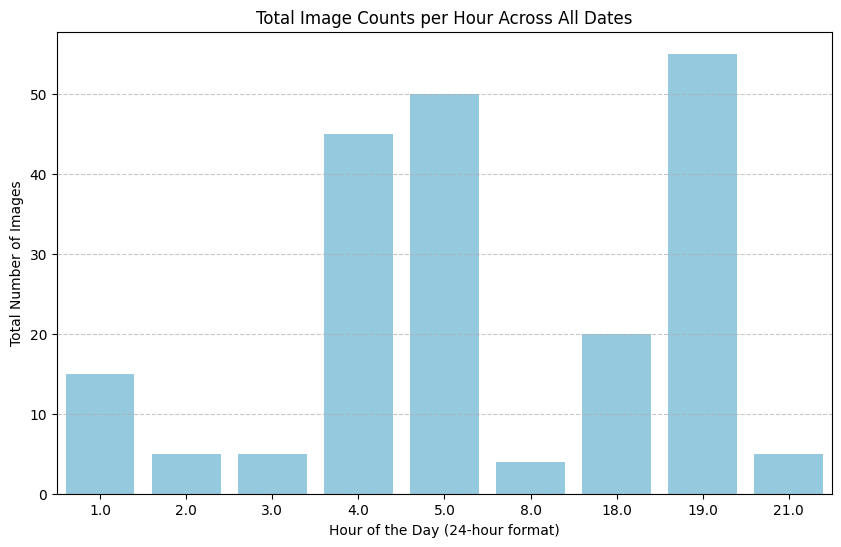

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate image counts by hour across all dates
hourly_counts = df.groupby('hour').size().reset_index(name='total_image_count')

# Sort by hour for proper plotting order
hourly_counts = hourly_counts.sort_values('hour')

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='hour', y='total_image_count', data=hourly_counts, color='skyblue')
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Total Number of Images')
plt.title('Total Image Counts per Hour Across All Dates')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

=== Full Date × Hour Table (0–23) ===
hour        1.0   2.0   3.0   4.0   5.0   8.0   18.0  19.0  21.0
date_only                                                       
2025-09-01     0     0     0    15     5     0     0     0     5
2025-09-02     0     0     0     0     5     0     0     5     0
2025-09-03     0     0     0     5     0     4     0     5     0
2025-09-04     0     0     0     5     0     0     0    10     0
2025-09-05     0     0     0     5     0     0     5     0     0
2025-09-06     0     0     0     0     5     0    10     5     0
2025-09-07     0     0     0     0     0     0     5     0     0
2025-09-09     0     5     0     0     0     0     0     0     0
2025-09-10     0     0     0    15    25     0     0     5     0
2025-09-12     0     0     0     0     0     0     0    15     0
2025-09-13     5     0     0     0     0     0     0     0     0
2025-09-15     0     0     0     0     0     0     0     5     0
2025-09-16    10     0     5     0    10     0     0

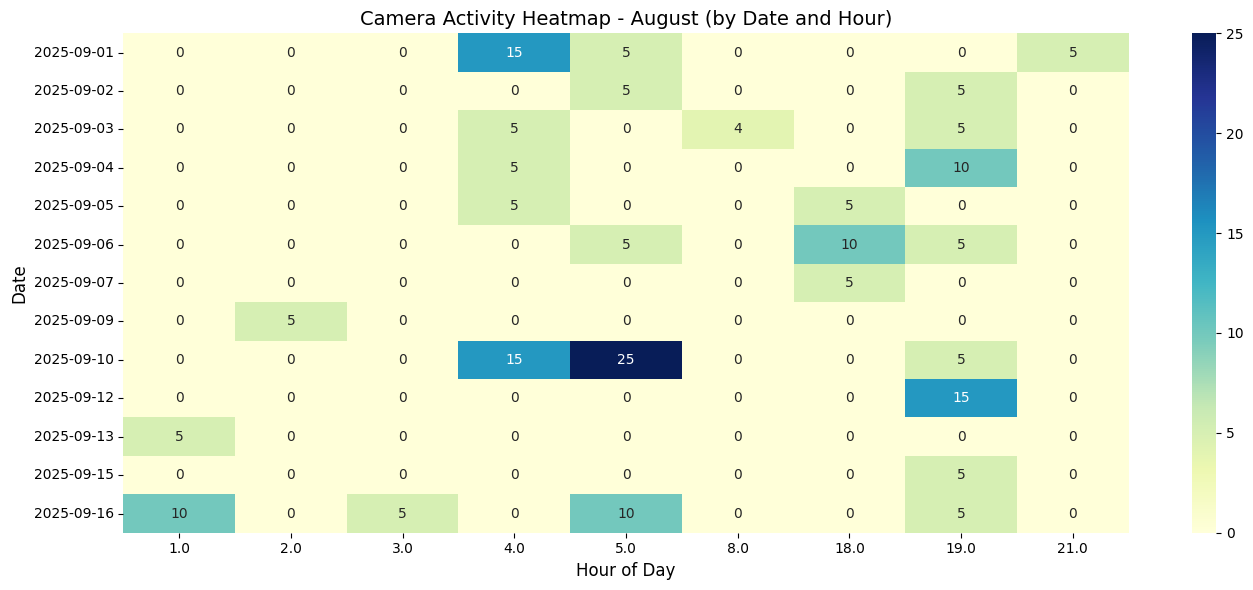

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your file (replace path if needed)
df = pd.read_csv("results.csv")

# Combine date and time into one datetime column
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], errors="coerce")

# Extract date and hour
df["date_only"] = df["datetime"].dt.date
df["hour"] = df["datetime"].dt.hour

# --- Full 24-hour table ---
full_table = (
    df.groupby(["date_only", "hour"]).size().reset_index(name="image_count")
    .pivot(index="date_only", columns="hour", values="image_count")
    .fillna(0).astype(int)
)

print("=== Full Date × Hour Table (0–23) ===")
print(full_table)

# --- Condensed summary ---
condensed = (
    df.groupby(["date_only", "hour"]).size().reset_index(name="image_count")
)

print("\n=== Condensed Summary (Only Active Hours) ===")
for date, group in condensed.groupby("date_only"):
    print(f"\nDate: {date}")
    for _, row in group.iterrows():
        print(f"  Hour {int(row['hour']):02d}: {row['image_count']} images")

# --- Heatmap Plot ---
plt.figure(figsize=(14, 6))
sns.heatmap(full_table, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Camera Activity Heatmap - August (by Date and Hour)", fontsize=14)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Date", fontsize=12)
plt.tight_layout()
plt.show()